In [1]:
## Imports
import xarray as xr
import numpy as np
import pandas as pd

import time
import importlib
import dask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Put us in the right repo for local relative pathing
import os
__repo__="/g/data/en0/jwg574/repos/simple_fire_metric/"
os.chdir(__repo__)

import fio,plotting

# Extreme value models

# Return Periods

 - pyextremes: https://georgebv.github.io/pyextremes/user-guide/6-return-periods/
     - try on single cell
     - loop over Australia
     - $ P = \frac{r-\alpha}{n+1-\alpha-\beta} $
         - P = Probability of exceedence
         - r = rank of extreme value (1 to n)
         - n = number of extreme values
         - $\alpha$, $\beta$ position parameters

In [5]:
ds = fio.ERA5_read_dailymaximums()

print(ds.time[1826],ds.time[24106])

# (1960 - 2020)
test_ffdi = ds.FFDI[1826:24106,100,50]
print(test_ffdi.shape)


<xarray.DataArray 'time' ()>
array('1960-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1960-01-01 <xarray.DataArray 'time' ()>
array('2020-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-12-31
(22280,)


# Yearly block sizes
- limited to return periods greater than 1
- close to 1 is also weird

In [3]:
from pyextremes import EVA



                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          FFDI      Size:                              22,280
Start:                       January 1960      End:                        December 2020
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 61      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

(<Figure size 384x384 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='FFDI'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='FFDI', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

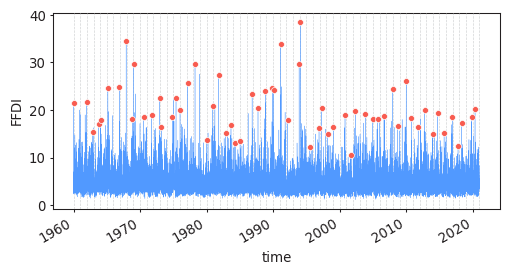

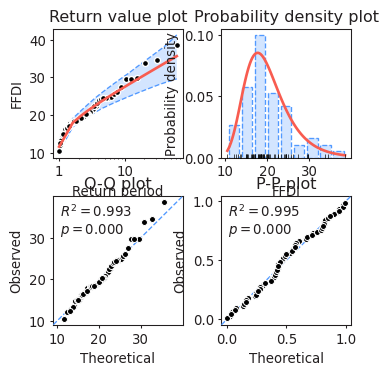

In [6]:
%%time

model = EVA(test_ffdi.to_dataframe().FFDI)
# block maximums (get yearly max)
model.get_extremes(method="BM", block_size="365.2425D")
# show time series and yearly maxima
model.plot_extremes(figsize=[6,3])

# take extremes and fit to some model
model.fit_model(distribution='genextreme')
# show estimates for return periods
summary = model.get_summary(
    return_period=[1.01, 5, 10],
    alpha=0.95,
    n_samples=1000,
)
print(model)
print(summary)
model.plot_diagnostic(alpha=.95, figsize=[4,4])

# what about with monthly block time
- return periods look like they are in years
- maybe issue in seasonal cycle

In [8]:
%%time

month_block = "%.4fD"%(365.2425/12.0)
print(month_block)

model_m = EVA(test_ffdi.to_dataframe().FFDI)
# block maximums (get yearly max)
model_m.get_extremes(method="BM", block_size=month_block)
# show time series and yearly maxima
model_m.plot_extremes(figsize=[6,3])

# take extremes and fit to some model
model_m.fit_model()
# show estimates for return periods
summary_m = model_m.get_summary(
    return_period=[1,5,10, 12, 60, 120],
    alpha=0.95,
    n_samples=1000,
)
print(summary_m)
print(model_m)
model_m.plot_diagnostic(alpha=.95,figsize=[4,4])

30.4369D
               return value   lower ci   upper ci
return period                                    
1.0               17.505998  16.769602  18.325200
5.0               25.317837  23.185605  27.607169
10.0              29.345826  26.327908  32.593361
12.0              30.484051  27.206807  34.070733
60.0              42.190032  35.668983  49.858478
120.0             48.293863  39.765823  58.853738
                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          FFDI      Size:                              22,280
Start:                       January 1960      End:                        December 2020
                                     Extreme Values                                     
---------------------------------------------------------

(<Figure size 384x384 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='FFDI'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='FFDI', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

# What is difference between u10 and u10n in ERA5

- u10n does vertical interpolation assuming neutral stability
- should only be minor differences

  

In [2]:
ds = fio.ERA5_read_month(['u10','v10','u10n','v10n'],'2019-12')

0.3.0


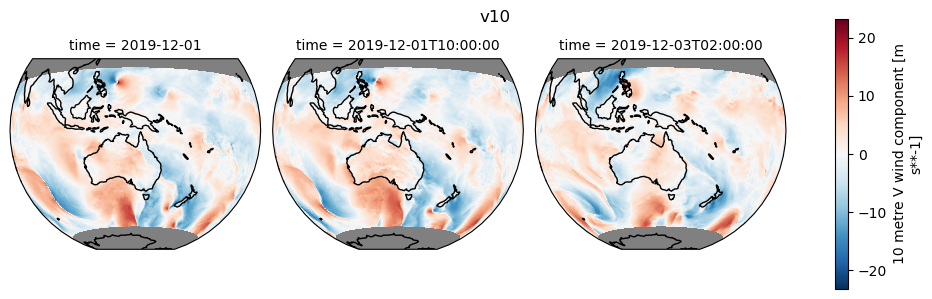

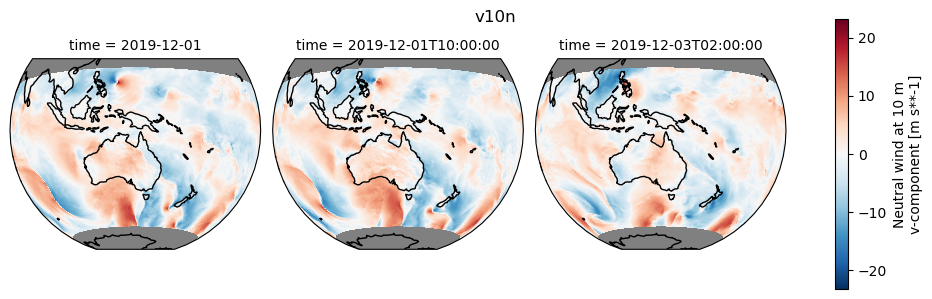

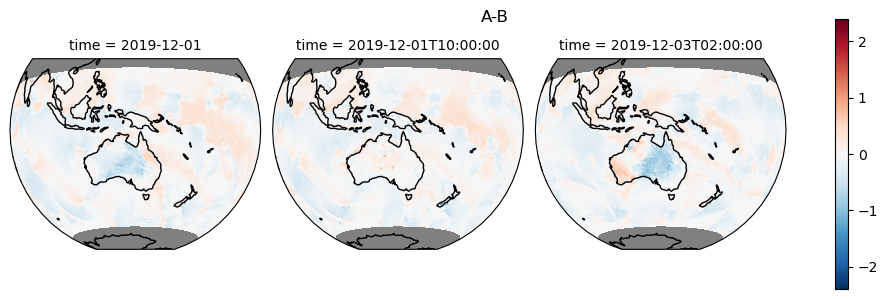

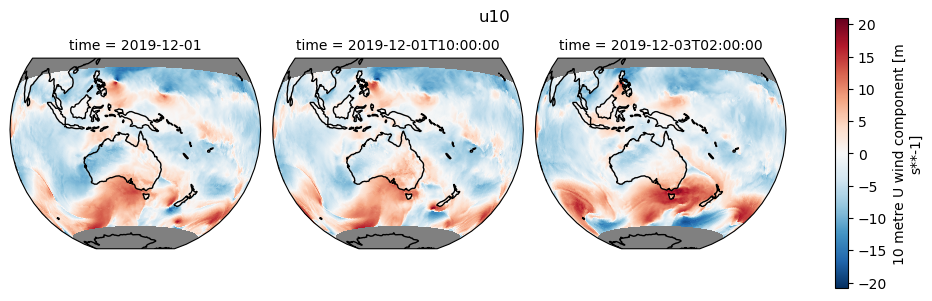

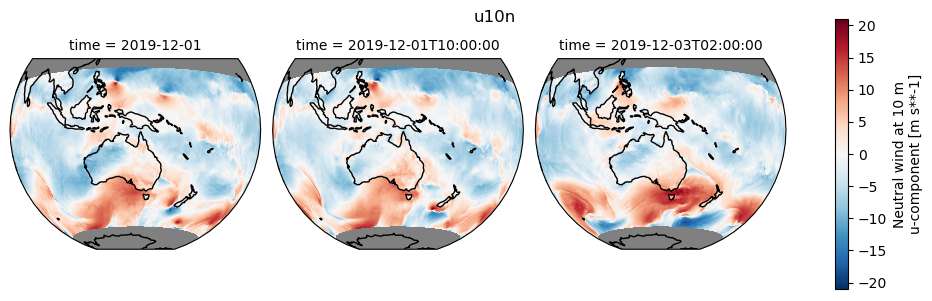

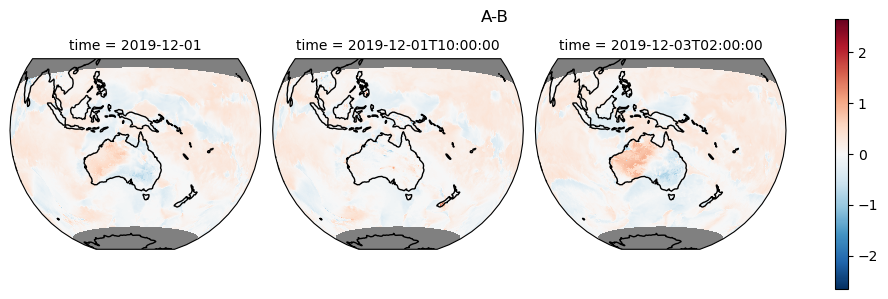

In [4]:
plotting.plot_diff_quick(ds.v10,ds.v10n,itimes=[0,10,50])
plotting.plot_diff_quick(ds.u10,ds.u10n,itimes=[0,10,50])

In [7]:
ds = fio.calc_s10(ds,u10='u10n',v10='v10n')
ds = ds.rename({'s10':'s10n'})
ds = fio.calc_s10(ds,u10='u10',v10='v10')

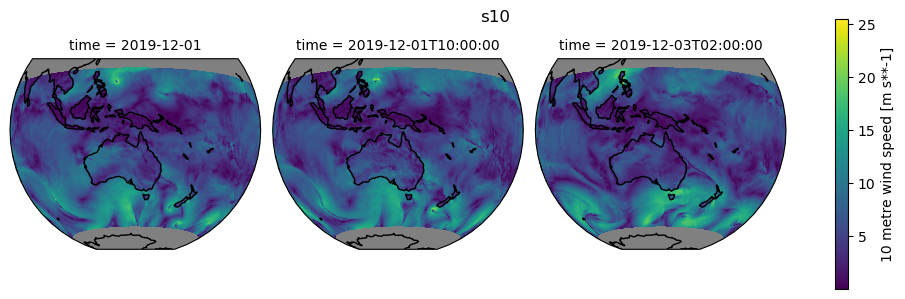

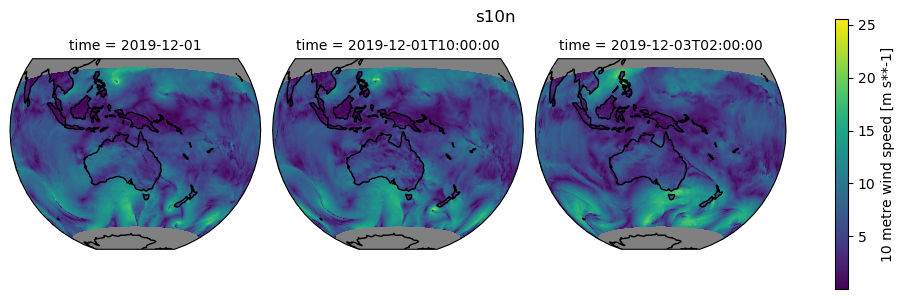

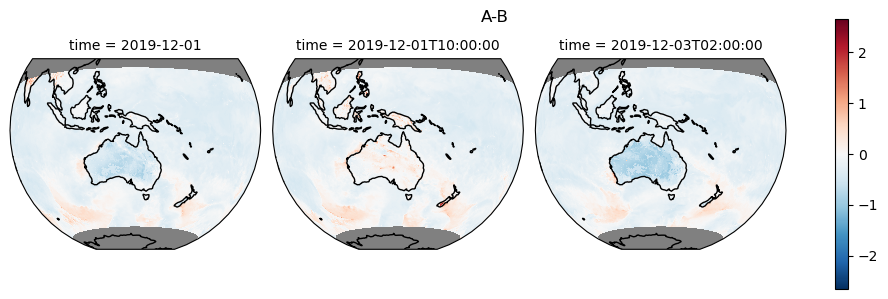

In [9]:
plotting.plot_diff_quick(ds.s10,ds.s10n,itimes=[0,10,50])